created by **Farah Rabie** (fr2007@hw.ac.uk)

This notebook is on the classification of lithology types based on the well log data distribution. The **3 tasks** covered in this notebook include:

- Visualisation of well log data distribution;
- Performing classification using K-Nearest Neighbours.
- Performing classification using the Random Forest Classifier.

The data in this notebook is sourced from the Equinor Volve Field dataset.

#### Notebook 2$\,\,\,\,\,$Multi-Class Lithology Classification

#### Import Libraries

<span style="color:red">Import the following Python libraries: </span>

- <span style="color:red">Pandas</span> (use alias *pd*)
- <span style="color:red">PyPlot sub-module from Matplotlib</span> (use alias *plt*)
- <span style="color:red">Seaborn</span> (use alias *sns*)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

We will also be importing multiple sub-modules from **sklearn**, a Python library for machine learning and data mining. It provides simple and efficient tools for data analysis and modeling. In this notebook, we will be using scikit-learn to implement machine learning algorithms for A classification task on well log data.

In [2]:
# import sklearn modules for model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In this notebook, we are looking at two different classifiers:

**K-Nearest Neighbors** (*from sklearn.neighbors import KNeighborsClassifier*)


K-Nearest Neighbors (KNN) is a simple, instance-based algorithm used for classification by finding the majority class among the $k$ nearest neighbors of a given point in the feature space. It works by calculating distances (commonly Euclidean) from the query point to all training points, selecting the nearest $k$ points, and assigning the most frequent class to the query point. KNN is non-parametric and easy to implement but can be computationally expensive as it requires evaluating the entire dataset for every prediction. It can also be sensitive to noise and irrelevant features.

In [3]:
# import the KNeighborsClassifier model from scikit-learn for classification tasks
from sklearn.neighbors import KNeighborsClassifier

**Random Forest Classifier** (from sklearn.ensemble import RandomForestClassifier)


Random Forest is an ensemble learning method that builds multiple decision trees and combines their predictions to improve classification accuracy. Each tree in the forest is trained on a random subset of the data, and predictions are made based on a majority vote across all trees. Random Forest is robust to overfitting, handles high-dimensional data well, and works efficiently with both classification and regression tasks. However, it can be more complex and less interpretable than simpler models like KNN.

In [4]:
# import the RandomForestClassifier model from scikit-learn for classification tasks
from sklearn.ensemble import RandomForestClassifier

#### Task 1$\,\,\,\,\,$Visualise Well Log Data Distribution

<span style="color:red"> Complete the following tasks:</span>


- Load the data from the *combined_well_data_with_lithology.csv* file into the **well_data** DataFrame, and inspect its content.
- Remove any missing values.
- Identify the different lithology types recorded in the dataset.

In [5]:
well_data = pd.read_csv('../../Data/combined_well_data_with_lithology.csv')
well_data.head()

,Well Name,Depth,GR,NPHI,RHOB,RT,DT,Lithology_values,Lithology
0,15_9-F-12,239.8776,NaN,NaN,NaN,0.1015,NaN,NaN,NaN
1,15_9-F-12,240.0300,NaN,NaN,NaN,0.1000,NaN,NaN,NaN
2,15_9-F-12,240.1824,NaN,NaN,NaN,0.1000,NaN,NaN,NaN
3,15_9-F-12,240.3348,NaN,NaN,NaN,0.1000,NaN,NaN,NaN
4,15_9-F-12,240.4872,20.9848,NaN,NaN,0.1000,NaN,NaN,NaN


In [6]:
well_data.dropna(inplace=True)

In [7]:
lithology_count = well_data['Lithology'].nunique()
print('Number of distinct classes in Lithology:', lithology_count)
lithology_labels = well_data['Lithology'].unique()
print('Distinct classes in Lithology:', lithology_labels)

Number of distinct classes in Lithology: 6
Distinct classes in Lithology: ['clay-shale' 'sandstone' 'limestone' 'marl' 'coal-lignite' 'silt']


<br>In a classification problem, a _target variable_ refers to the specific variable a classifier model is trained to predict. It is important to explore and validate the target variable before feeding it into the classifier. <span style="color:purple">The target variable of this classification problem is _lithology_</span>. 

To better understand the distribution of lithology types within the dataset, we can <span style="color:purple">use the value_counts() function on the $Lithology$ column</span>. This will provide a count of each unique lithology type present in the well log data, allowing us to assess the balance of classes and identify any potential imbalances that may affect our classification model.

In [8]:
well_data['Lithology'].value_counts()

Lithology
sandstone       15212
clay-shale      10343
limestone        6644
silt             3265
marl             2012
coal-lignite       29
Name: count, dtype: int64

Notice how _coal-lignite_ has a significantly smaller count compared to other classes. This imbalance can lead to challenges in model training, as the model might be biased towards the majority classes. A choice has to be made here on whether or not to include this class, based on its importance for this analysis. 

<span style="color:red"> Will you be including the _coal-lignite_ class is this analysis?</span>


Comment the line in the following cells if you decide on including it.

In [9]:
well_data = well_data[well_data['Lithology'] != 'coal-lignite']

To examine the distribution and relationships among the well log features, we can use *pairplots*. 

<span style="color:red"> Plot the pairplots you would like to visualise.</span>

<Figure size 400x400 with 0 Axes>

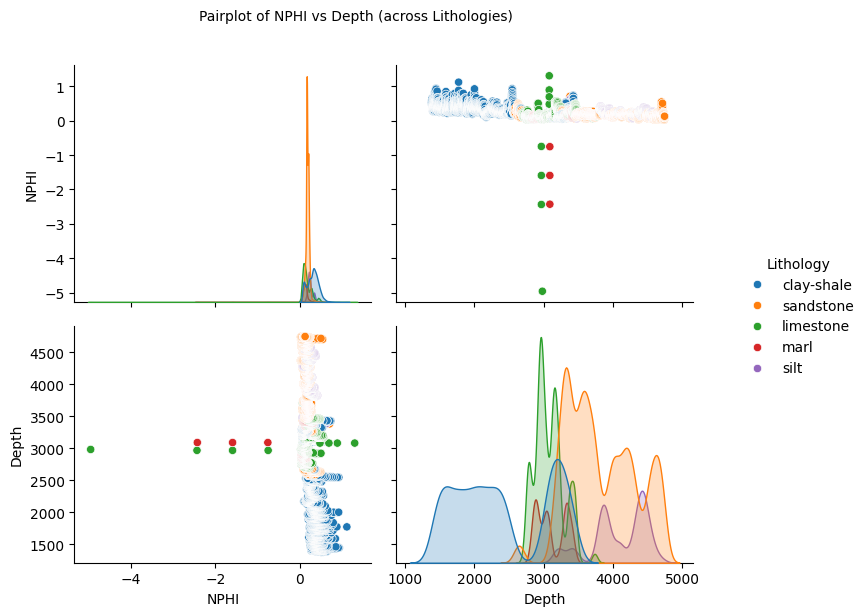

In [10]:
subset_nphi_rhob = well_data[['NPHI', 'Depth', 'Lithology']]

plt.figure(figsize=(4, 4))

# create pairplot
g = sns.pairplot(
    subset_nphi_rhob, 
    hue='Lithology', 
    height=3, 
    diag_kind='kde', 
    palette='tab10', 
    plot_kws=dict(marker="o", alpha=1.0)
)

plt.suptitle('Pairplot of NPHI vs Depth (across Lithologies)', fontsize=10, y=1.02) # add main title
g._legend.set_bbox_to_anchor((1.20, 0.5))  # position legend to right
plt.setp(g._legend.get_title(), fontsize=10)  # set title for legend
plt.tight_layout() # adjust layout
plt.subplots_adjust(hspace=0.1) # adjust hspace value to increase/decrease space between rows of plots
        
plt.show()

#### Task 2$\,\,\,\,\,$Prepare Data for Classification Task

We start by <span style="color:purple">printing a list of available *input variables* in the **well_data** DataFrame</span>.

In [11]:
print('List of input variables in DataFrame:', well_data.columns.tolist())

List of input variables in DataFrame: ['Well Name', 'Depth', 'GR', 'NPHI', 'RHOB', 'RT', 'DT', 'Lithology_values', 'Lithology']


In [12]:
# splitting data by well names
def well_splitter(dataframe, groupby_column):
    grouped = dataframe.groupby(groupby_column)
    
    # create empty lists
    wells_as_dfs = []
    wells_wellnames = []

    # split up the data by well
    for well, data in grouped:
        wells_as_dfs.append(data)
        wells_wellnames.append(well)

    print('index  wellname')
    for i, name in enumerate(wells_wellnames):
        print(f'{i}      {name}')
    
    return wells_as_dfs, wells_wellnames

dfs_wells, wellnames = well_splitter(well_data, 'Well Name')

index  wellname
0      15_9-F-1 B
1      15_9-F-11 B
2      15_9-F-12
3      15_9-F-15 C
4      15_9-F-4
5      15_9-F-5


In [13]:
training_wells = pd.concat([dfs_wells[0], dfs_wells[1], dfs_wells[2], dfs_wells[3]])
training_well_names = [wellnames[0], wellnames[1], wellnames[2], wellnames[3]]

testing_wells = pd.concat([dfs_wells[4], dfs_wells[5]])
testing_well_names = [wellnames[4], wellnames[5]]

In [14]:
testing_wells.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7827 entries, 70527 to 97479
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Well Name         7827 non-null   object 
 1   Depth             7827 non-null   float64
 2   GR                7827 non-null   float64
 3   NPHI              7827 non-null   float64
 4   RHOB              7827 non-null   float64
 5   RT                7827 non-null   float64
 6   DT                7827 non-null   float64
 7   Lithology_values  7827 non-null   float64
 8   Lithology         7827 non-null   object 
dtypes: float64(7), object(2)
memory usage: 611.5+ KB


We then <span style="color:purple">select our input features</span> — Gamma Ray ($GR$), Neutron Porosity ($NPHI$), Bulk Density ($RHOB$), Resistivity ($RT$), and Density Time ($DT$) — and <span style="color:purple">set the target variable</span> as $Lithology$.

In [15]:
X = training_wells[['GR', 'NPHI', 'RHOB', 'RT', 'DT']] # input variables
y = training_wells['Lithology'] # target variable

In [16]:
# combine X and y into a single DataFrame
combined = pd.concat([X, y], axis=1)

# shuffle the combined DataFrame
shuffled_combined = shuffle(combined, random_state=42)

# split back into X and y
X_train = shuffled_combined.iloc[:, :-1]  # all columns except the last one
y_train = shuffled_combined.iloc[:, -1]    # the last column

In [17]:
X_test = testing_wells[['GR', 'NPHI', 'RHOB', 'RT', 'DT']]
y_test = testing_wells['Lithology'] 

# combine X and y into a single DataFrame
combined_test = pd.concat([X_test, y_test], axis=1)

# shuffle the combined DataFrame
shuffled_combined_test = shuffle(combined_test, random_state=42)

# split back into X and y
X_test = shuffled_combined_test.iloc[:, :-1]  # all columns except the last one
y_test = shuffled_combined_test.iloc[:, -1]    # the last column

test_df = X_test 

#### Task 3$\,\,\,\,\,$Perform Classification using K-Nearest Neighbours

Scaling the data is crucial for the KNN algorithm, as it is sensitive to the scale of the data. We can now <span style="color:purple">initialise a *StandardScaler* to standardise our features</span>, ensuring that they have a mean of 0 and a standard deviation of 1.

In [18]:
# initialize the StandardScaler object
scaler = StandardScaler()

# fit the StandardScaler to the training data and transform the training data
# fit: calculates the mean and standard deviation of the training data
# transform: standardises the training data using these statistics
X_train_KNN = scaler.fit_transform(X_train)

# apply the StandardScaler to the test data using the same mean and standard deviation
# note: Only transform is used here, not fit, to ensure the test data is scaled consistently with the training data
X_test_KNN = scaler.transform(X_test)

We can now <span style="color:purple">initialise the KNeighborsClassifier</span>, and fit it to the training data.

In [19]:
KNeighbors_classifier = KNeighborsClassifier() # initialise the KNeighborsClassifier

# fit the model to the training data, by training the KNeighborsClassifier on X_train and y_train
KNeighbors_classifier.fit(X_train_KNN, y_train)

KNeighborsClassifier()

Now that we have trained a *KNeighbors_classifier* model, let us <span style="color:purple">test it and evaluate its performance</span>. 

In [20]:
# predict the target variable for the input variables from the test set
y_pred_KNN = KNeighbors_classifier.predict(X_test_KNN)

# how accurate were the predictions?
# the accuracy is the proportion of correctly predicted labels out of the total number of predictions
accuracy = accuracy_score(y_test, y_pred_KNN)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.58


We can also <span style="color:purple">add the actual lithology labels and the predicted labels to the **test_df** DataFrame</span> and <span style="color:purple">display the first few rows to compare the results</span>.

In [21]:
# generate predictions
predictions = KNeighbors_classifier.predict(X_test_KNN)

# add actual and predicted labels
test_df['Actual_Lithology'] = y_test.values  # Ensure y_test is converted to a numpy array if needed
test_df['Predicted_Lithology'] = predictions
    
# display the first few rows of the new DataFrame
print(test_df.head())

            GR    NPHI    RHOB    RT      DT Actual_Lithology  \
71669   15.144  0.1616  2.4686  1.66  76.087        limestone   
94386   48.540  0.1673  2.6201  2.45  75.286        limestone   
73119  116.321  0.3124  2.4545  1.94  91.013       clay-shale   
72204   33.654  0.0998  2.5995  5.53  67.799             marl   
92845   13.760  0.0924  2.6200  3.82  65.160        limestone   

      Predicted_Lithology  
71669           limestone  
94386           limestone  
73119          clay-shale  
72204          clay-shale  
92845          clay-shale  


<br><span style="color:purple">Let us visualise our results</span>.

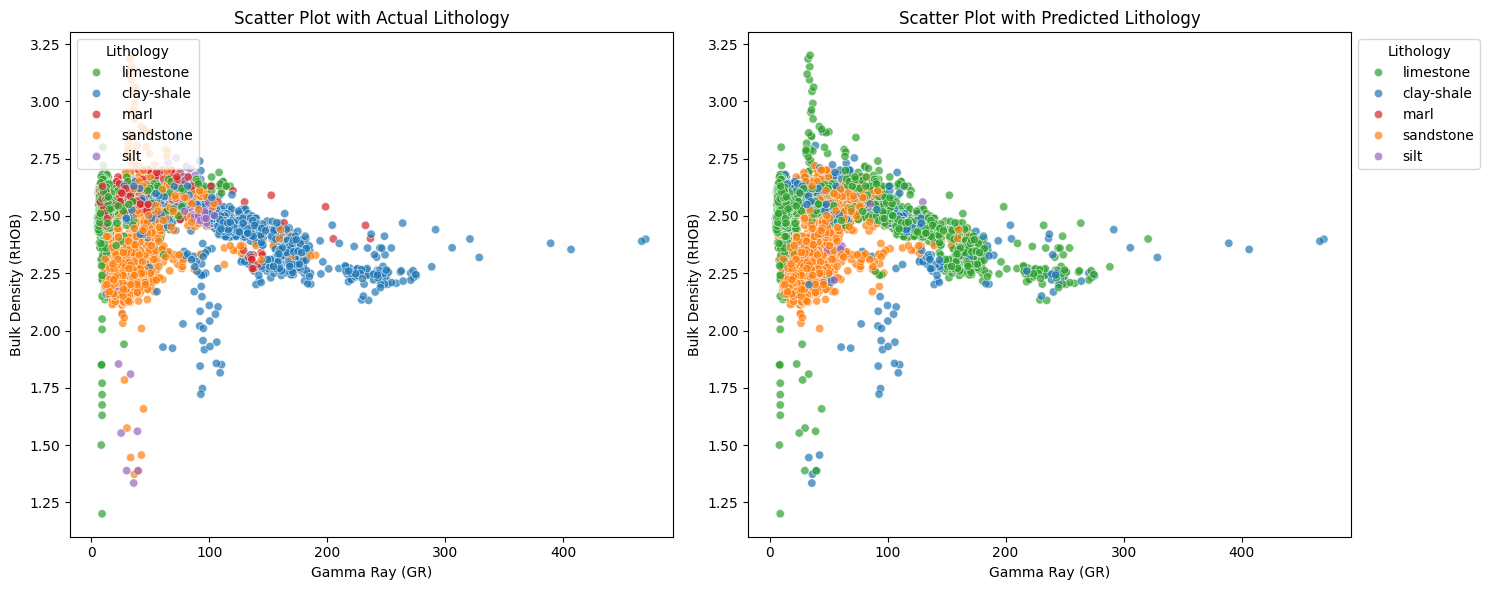

In [22]:
# define a color palette for the lithology classes
custom_palette = {
    'clay-shale': '#1f77b4',  # blue
    'sandstone': '#ff7f0e',   # orange
    'limestone': '#2ca02c',   # green
    'marl': '#d62728',        # red
    'silt': '#9467bd'         # purple
}

# create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# first subplot: scatter plot by actual lithology
sns.scatterplot(ax=axes[0], 
                x=test_df['GR'], 
                y=test_df['RHOB'], 
                hue=test_df['Actual_Lithology'], 
                palette=custom_palette, 
                alpha=0.7)
axes[0].set_title('Scatter Plot with Actual Lithology')
axes[0].set_xlabel('Gamma Ray (GR)')
axes[0].set_ylabel('Bulk Density (RHOB)')
axes[0].legend(title='Lithology', loc='upper left')

# second subplot: scatter plot by predicted lithology
sns.scatterplot(ax=axes[1], 
                x=test_df['GR'], 
                y=test_df['RHOB'], 
                hue=test_df['Predicted_Lithology'], 
                palette=custom_palette, 
                alpha=0.7)
axes[1].set_title('Scatter Plot with Predicted Lithology')
axes[1].set_xlabel('Gamma Ray (GR)')
axes[1].set_ylabel('Bulk Density (RHOB)')
axes[1].legend(title='Lithology', loc='upper left')

# create a custom legend
handles, labels = axes[0].get_legend_handles_labels()
axes[1].legend(handles, labels, title='Lithology', loc='upper left', bbox_to_anchor=(1, 1))

# adjust layout for better spacing
plt.tight_layout()
plt.show()

We can also generate a classification report, with the following metrics:

**Precision**
<br>The ratio of correctly predicted (positive) observations to the total (positive) predictions.


**Recall**
<br>The ratio of correctly predicted positive observations to all observations in the actual class. It shows how many of the actual positives were correctly predicted.

**F1-Score**
<br>The harmonic mean of precision and recall. It provides a single metric that balances both precision and recall.

**Support**
<br>The number of actual occurrences of the class in the specified dataset.

Precision and recall seem similar, but are different metrics. Take the example of a model that predicts whether a patient has a certain disease:
_Precision_ would tell us how many patients actually have the disease, out of all the patients that the model predicted as having the disease (so, true positives + false positive). Recall, on the other hand, tells us how many patients with the disease were correctly identified by the model, out of all the patients who actually have the disease (i.e., true positive + false negative).
hint: _true positive_ : second word indicates what the model tells you, and the first word indicates whether or not the model was right.

In [23]:
print(classification_report(y_test, y_pred_KNN))

              precision    recall  f1-score   support

  clay-shale       0.36      0.24      0.29      1429
   limestone       0.50      0.88      0.64      2518
        marl       0.17      0.00      0.00      1325
   sandstone       0.81      0.87      0.84      2255
        silt       0.05      0.00      0.01       300

    accuracy                           0.58      7827
   macro avg       0.38      0.40      0.36      7827
weighted avg       0.49      0.58      0.50      7827



A *confusion matrix* is a table used to evaluate the performance of a classification model by comparing predicted and actual values. It displays the counts of true positives, true negatives, false positives, and false negatives, which help assess the accuracy, precision, and recall of the model. This matrix provides insights into the the ability of the model to correctly classify different categories and identify areas where it may be making errors.

To wrap us this task, let us <span style="color:purple">create and visualise a *confusion matrix, and visualise it*</span>.

In [24]:
confusion_matrix_KNN = confusion_matrix(y_test, y_pred_KNN)
print('Confusion Matrix:', confusion_matrix_KNN)

Confusion Matrix: [[ 340  864    2  221    2]
 [ 200 2226    0   90    2]
 [ 299  975    1   49    1]
 [  80  195    2 1964   14]
 [  18  191    1   89    1]]


Text(120.72222222222221, 0.5, 'Actual Lithology')

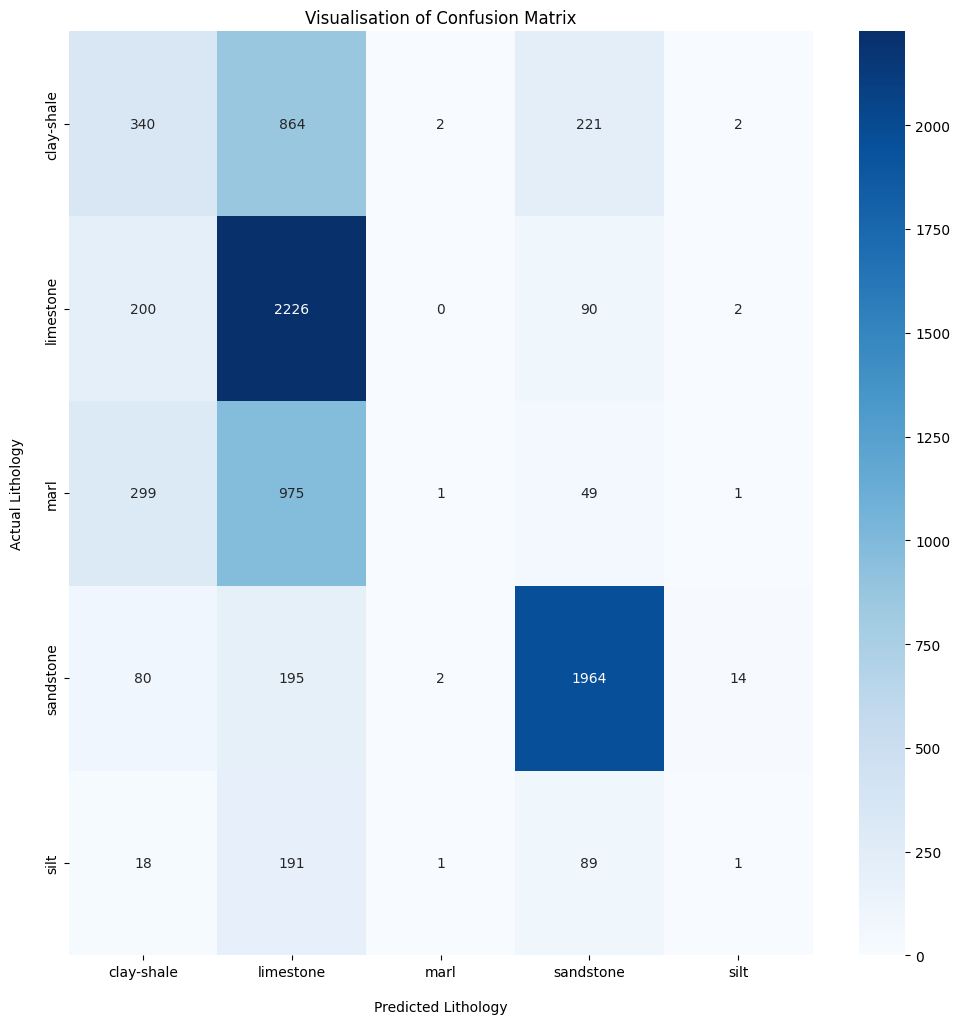

In [25]:
labels = ['clay-shale', 'sandstone', 'limestone', 'marl','silt']
labels.sort()
fig = plt.figure(figsize=(12,12))
ax = sns.heatmap(confusion_matrix_KNN , annot=True, cmap='Blues', fmt='.0f', xticklabels=labels,  yticklabels = labels)

ax.set_title('Visualisation of Confusion Matrix')
ax.set_xlabel('Predicted Lithology', labelpad=15)
ax.set_ylabel('Actual Lithology', labelpad=15)

#### Task 4$\,\,\,\,\,$Perform Classification using Random Forest Classifier

Now that we have worked with the K-Nearest Neighbors (KNN) algorithm, <span style="color:red">can you try running the Random Forest Classifier?</span> You'll need to reset the data, but there is no need to scale it this time.

Accuracy: 0.63
              precision    recall  f1-score   support

  clay-shale       0.57      0.37      0.45      1429
   limestone       0.53      0.91      0.67      2518
        marl       0.07      0.00      0.00      1325
   sandstone       0.81      0.92      0.86      2255
        silt       0.10      0.01      0.01       300

    accuracy                           0.63      7827
   macro avg       0.42      0.44      0.40      7827
weighted avg       0.53      0.63      0.55      7827

Confusion Matrix: [[ 531  680   10  203    5]
 [ 106 2287    3  122    0]
 [ 201 1066    1   57    0]
 [  28  135    0 2078   14]
 [  58  140    0  100    2]]


Text(120.72222222222221, 0.5, 'Actual Lithology')

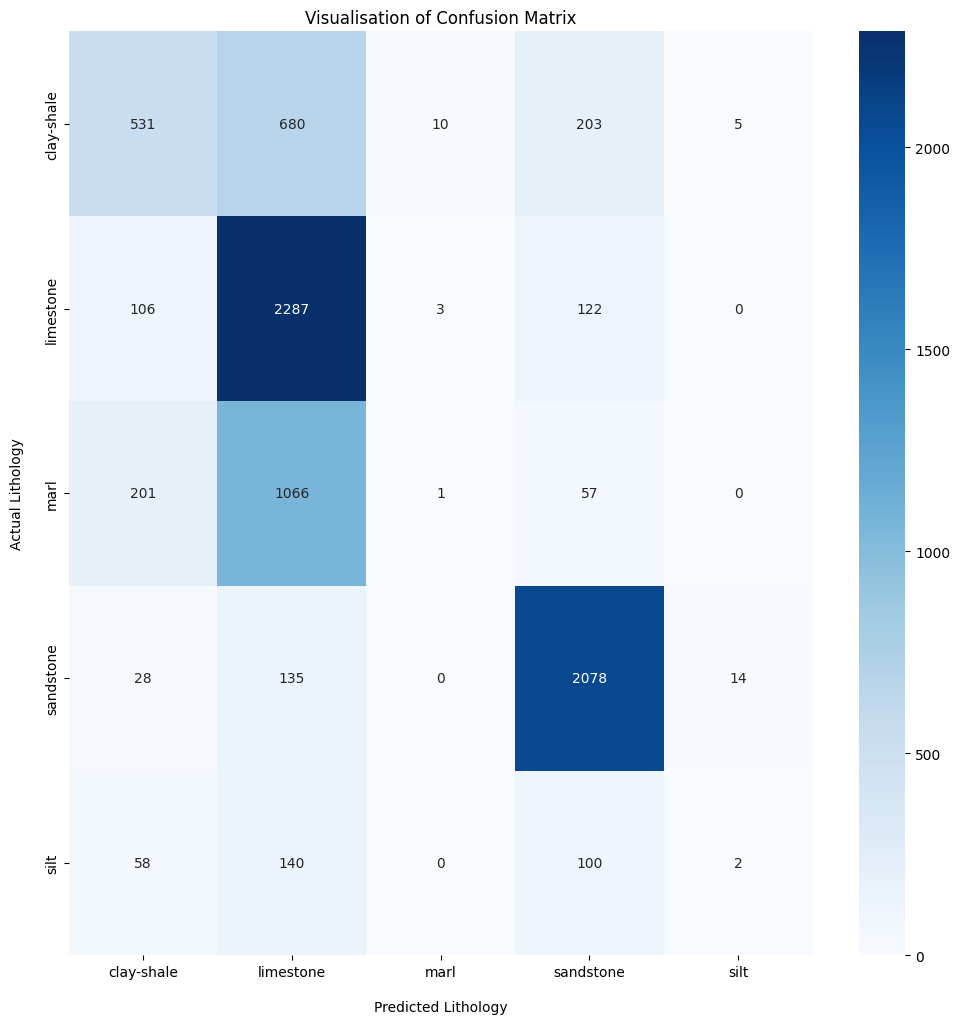

In [26]:
X_train = X_train.drop(columns=['Actual_Lithology', 'Predicted_Lithology'], errors='ignore')
X_test = X_test.drop(columns=['Actual_Lithology', 'Predicted_Lithology'], errors='ignore')

# initialise the RandomForestClassifier
random_forest_classifier = RandomForestClassifier()

# fit the model to the training data, by training the RandomForestClassifier on X_train and y_train
random_forest_classifier.fit(X_train, y_train)

# predict the target variable for the input variables from the test set
y_pred_RF = random_forest_classifier.predict(X_test)

# how accurate were the predictions?
# the accuracy is the proportion of correctly predicted labels out of the total number of predictions
accuracy = accuracy_score(y_test, y_pred_RF)
print(f'Accuracy: {accuracy:.2f}')

# generate classification report
print(classification_report(y_test, y_pred_RF))

# print confusion matrix
confusion_matrix_RF = confusion_matrix(y_test, y_pred_RF)
print('Confusion Matrix:', confusion_matrix_RF)

fig = plt.figure(figsize=(12,12))
ax = sns.heatmap(confusion_matrix_RF , annot=True, cmap='Blues', fmt='.0f', xticklabels=labels,  yticklabels = labels)

ax.set_title('Visualisation of Confusion Matrix')
ax.set_xlabel('Predicted Lithology', labelpad=15)
ax.set_ylabel('Actual Lithology', labelpad=15)

**Reference**

- Equinor, A. S. A. (2023). Volve field data set.
- Andy McDonald. (2020). Petrophysics-Python-Series/27 - Random Forest for Lithology Classification - Multi Class Output.ipynb at master · andymcdgeo/Petrophysics-Python-Series. GitHub. https://github.com/andymcdgeo/Petrophysics-Python-Series/blob/master/27%20-%20Random%20Forest%20for%20Lithology%20Classification%20-%20Multi%20Class%20Output.ipynb
- Andy McDonald. (2020). Petrophysics-Python-Series/37 - Classification with K-Nearest Neighbors.ipynb at master · andymcdgeo/Petrophysics-Python-Series. GitHub. https://github.com/andymcdgeo/Petrophysics-Python-Series/blob/master/37%20-%20Classification%20with%20K-Nearest%20Neighbors.ipynb